## 1. 의존성 설치

In [45]:
!pip -q install wandb

## 2. 환경설정
- 의존성 설정
- 데이터 폴더 및 파인튜닝용 프롬프트 생성 (dataset_info.json)

In [84]:
# for common
import os
import json
import wandb
import boto3, botocore
import sagemaker
from sagemaker import get_execution_role

# for resizing
from pathlib import Path
from PIL import Image
from torchvision import transforms

# for training
from sagemaker import image_uris, model_uris, script_uris

from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.parameter import ContinuousParameter, IntegerParameter
from sagemaker.tuner import HyperparameterTuner

# for inference
import matplotlib.pyplot as plt
import numpy as np
from sagemaker.predictor import Predictor

In [85]:
try:
    aws_role = sagemaker.get_execution_role()
except:
    iam = boto3.client("iam")
    # TODO: replace with your role name (i.e. "AmazonSageMaker-ExecutionRole-20211014T154824")
    aws_role = iam.get_role(RoleName="<replace with your RoleName>")["Role"]["Arn"]

boto_session = boto3.Session()
aws_region = boto_session.region_name
sess = sagemaker.Session(boto_session=boto_session)

print(aws_role)
print(aws_region)
print(sess.boto_region_name)

arn:aws:iam::981794133797:role/service-role/AmazonSageMaker-ExecutionRole-20230530T121636
us-east-1
us-east-1


## 3. 데이터셋 준비

- 파인튜닝 데이터의 기본 폴더는 `training_images`
- 다른 폴더를 사용하려면 `local_training_dataset_folder` 변경

In [86]:
local_training_dataset_folder = "training_images"
if not os.path.exists(local_training_dataset_folder):
    os.mkdir(local_training_dataset_folder)

---

- 위에서 생성한 폴더에 파인튜닝용 이미지 업로드하기
- **이미지 크기가 모두 같아야 함 - (512, 512) 권장**
- 또는 [점프스타트용](https://aws.amazon.com/ko/blogs/machine-learning/fine-tune-text-to-image-stable-diffusion-models-with-amazon-sagemaker-jumpstart/)으로 제공되는 이미지를 사용하려면 `use_local_images=True`

---

In [87]:
# If False, notebook will use the example dataset provided by JumpStart
use_local_images = True

if not use_local_images:
    # Downloading example dog images from JumpStart S3 bucket
    s3_resource = boto3.resource("s3")
    bucket = s3_resource.Bucket(f"jumpstart-cache-prod-{aws_region}")
    for obj in bucket.objects.filter(Prefix="training-datasets/dogs_sd_finetuning/"):
        bucket.download_file(
            obj.key, os.path.join(local_training_dataset_folder, obj.key.split("/")[-1])
        )  # save to same path

- 사용할 프롬프트 설정
- token 과 class_prompt 를 적절한 값으로 변경

In [88]:
token = ''.join(reversed('DONGKYL_FLAT'))
instance_prompt = f"{token} style"
class_prompt = "icon style"
validation_prompt = f"a red envelope on white background, {instance_prompt}"

instance_prompt, class_prompt, validation_prompt

('a TALF_LYKGNOD icon style', 'a icon style')

In [89]:
# Instance prompt is fed into the training script via dataset_info.json present in the training folder. Here, we write that file.
with open(os.path.join(local_training_dataset_folder, "dataset_info.json"), "w") as f:
    f.write(json.dumps({
        "instance_prompt": instance_prompt,
        "class_prompt": class_prompt,
        "validation_prompt": validation_prompt,
    }))

### 데이터셋 업로드
- 버킷 생성

In [90]:
mySession = boto3.session.Session()
AwsRegion = mySession.region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

s3 = boto3.client("s3")
s3.download_file(
    f"jumpstart-cache-prod-{AwsRegion}",
    "ai_services_assets/custom_labels/cl_jumpstart_ic_notebook_utils.py",
    "utils.py",
)
from utils import create_bucket_if_not_exists

In [91]:
training_bucket = f"stable-diffusion-dreambooth-{AwsRegion}-{account_id}"

create_bucket_if_not_exists(training_bucket)

train_s3_path = f"s3://{training_bucket}/{token.lower()}/"

Using an existing bucket stable-diffusion-dreambooth-us-east-1-981794133797


---

모든 이미지 사이즈가 동일해야함.
아래 코드는 학습용 이미지를 (512, 512) 사이즈로 리사이즈함.

size 를 512 등의 정수로 하면 가장 긴변의 길이를 512로 세팅하고 비율은 유지됨.

```python
size = (512, 512)

train_images_path = Path(local_training_dataset_folder)
image_transforms = transforms.Compose([
    transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR)
])

for image_path in train_images_path.iterdir():
    if image_path.is_dir() or image_path.suffix == '.json':
        continue
    train_image = Image.open(image_path)
    img = image_transforms(train_image)
    img.save(image_path)
```

---

---

Next we upload the training datasets (images and `dataset_info.json`) to the S3 bucket.

---


In [92]:
!aws s3 cp --recursive $local_training_dataset_folder $train_s3_path

upload: training_images/dataset_info.json to s3://stable-diffusion-dreambooth-us-east-1-981794133797/style_flat/dataset_info.json
upload: training_images/s-icons_social-media-icons_basic_round_set_gradient-color_512x512_0000_facebook.png to s3://stable-diffusion-dreambooth-us-east-1-981794133797/style_flat/s-icons_social-media-icons_basic_round_set_gradient-color_512x512_0000_facebook.png
upload: training_images/s-icons_social-media-icons_basic_round_set_gradient-color_512x512_0001_pinterest.png to s3://stable-diffusion-dreambooth-us-east-1-981794133797/style_flat/s-icons_social-media-icons_basic_round_set_gradient-color_512x512_0001_pinterest.png
upload: training_images/s-icons_social-media-icons_basic_round_set_gradient-color_512x512_0004_youtube.png to s3://stable-diffusion-dreambooth-us-east-1-981794133797/style_flat/s-icons_social-media-icons_basic_round_set_gradient-color_512x512_0004_youtube.png
upload: training_images/s-icons_social-media-icons_basic_round_set_gradient-color_51

## 4. 세이지메이커 학습작업으로 드림부스 파인튜닝

### 4.1. 트레이닝 파라미터 설정

- 기본 모델은 StableDiffusion 2.1 base 모델
- `train_model_uri` 를 세이지메이커 학습완료 모델의 output uri(s3) 로 변경하여 해당 모델에 추가학습 가능

In [93]:
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
training_instance_type = "ml.g5.2xlarge"

# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)
train_model_uri

---

- text-to-image 모델로 파인튜닝 한 모델 주소를 `train_model_uri` 에 업데이트

---

In [ ]:
# train_model_uri = 's3://sagemaker-us-east-1-981794133797/text-to-image-training/output/sd-text-to-image-2023-06-19-13-46-51-879/output/model.tar.gz'
# train_model_uri = 's3://sagemaker-us-east-1-981794133797/text-to-image-training/output/sd-text-to-image-2023-06-20-12-02-03-447/output/model.tar.gz'
train_model_uri = 's3://sagemaker-us-east-1-981794133797/text-to-image-training/output/sd-text-to-image-2023-06-20-15-39-54-782/output/model.tar.gz'
train_model_uri

---

- `src/train/build_and_push.sh` 로 학습이미지 ECR 에 푸시 후
- 해당 학습용 이미지 주소를 아래에 채우기

---

In [95]:
tag = '1bd4044249'  # update tag
train_image_uri = f'981794133797.dkr.ecr.us-east-1.amazonaws.com/dreambooth-training-gpu:{tag}'
train_image_uri

'981794133797.dkr.ecr.us-east-1.amazonaws.com/dreambooth-training-gpu:c4f28896e4'

---

- 모델파일 저장될 위치 지정

---

In [96]:
output_bucket = sess.default_bucket()
output_prefix = "dreambooth-style-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
s3_output_location

's3://sagemaker-us-east-1-981794133797/dreambooth-style-training/output'

### 4.2. 하이퍼파라미터 설정

---

- diffusers [dreambooth 예제](https://github.com/huggingface/diffusers/blob/v0.16.1/examples/dreambooth/train_dreambooth.py) 의 입력 파라미터를 사용
- `lr_scheulder` 는 `cosine` 으로 지정
---

In [97]:
8yperparameters = {
    'learning_rate': 1e-07,
    'max_train_steps': 8000,
    'num_train_epochs': 1,
    'batch_size': 1,
    'validation_steps': 25,
    'use_8bit_adam': True,
    'gradient_checkpointing': True,
    'gradient_accumulation_steps': 1,
    'lr_warmup_steps': 100,
    'train_text_encoder': True,
    'with_prior_preservation': False,
    'lr_scheduler': 'cosine_with_restarts',
    'lr_num_cycles': 1600,  # 5 cycles
}

hyperparameters

{'num_train_epochs': 20,
 'learning_rate': 2.0252840135881164e-06,
 'max_train_steps': 240,
 'compute_fid': True}

### 4.3. 학습하기

---

- HPO 를 이용하여 학습 (7개 작업을 동시에 진행)
- [FID](https://wandb.ai/wandb_fc/korean/reports/-Frechet-Inception-distance-FID-GANs---Vmlldzo0MzQ3Mzc) 를 이용하여 최적 학습결과 찾기
- Weights and Biases 를 이용할 경우 `use_wandb=True` 로 설정 하고 로그인

---

In [ ]:
training_job_name = f"dreambooth-{token.lower().replace('_', '-')}"
training_job_name

In [ ]:
use_wandb = True
if use_wandb:
    wandb.login()
    hyperparameters['report_to'] = 'wandb'
    environment = {
        'WANDB_API_KEY': '', #PASTE_YOUR_API_KEY,
        'WANDB_PROJECT': f'dreambooth-{token}',
    }

In [99]:
use_hpo = False

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    model_uri=train_model_uri,
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
    environment=environment if use_wandb else None,
)

if use_hpo:
    sd_estimator.set_hyperparameters(compute_fid="True")
    hyperparameter_ranges = {
        "learning_rate": ContinuousParameter(3e-07, 3e-06, "Linear"),
        "max_train_steps": IntegerParameter(200, 1200, "Linear"),
    }
    metric_definitions = [
        {'Name': 'fid_score', 'Regex': 'fid_score=([-+]?\\d\\.?\\d*)'},
    ]
    tuner_parameters = {
        "estimator": sd_estimator,
        "metric_definitions": metric_definitions,
        "objective_metric_name": "fid_score",
        "objective_type": "Minimize",
        "hyperparameter_ranges": hyperparameter_ranges,
        "max_jobs": 14,
        "max_parallel_jobs": 7,
        "strategy": "Bayesian",
        "base_tuning_job_name": training_job_name,
    }

    bayesian_tuner = HyperparameterTuner(**tuner_parameters)
    bayesian_tuner.fit({"training": train_s3_path}, wait=False)
else:
    sd_estimator.fit({"training": train_s3_path}, logs=True)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [100]:
training_job_name

'sd-dreambooth-model-txt2img-stabilityai-2023-05-30-08-29-09-372'

## 5. 세이지메이커 엔드포인트 생성

- 파인튜닝된 모델로 세이지메이커 엔드포인트 프로비저닝
- 엔드포인트 생성대신 `inference.ipynb` 노트북으로 직접 아이콘 생성도 가능

In [101]:
%time

inference_instance_type = "ml.g5.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


---

다른 엔드포인트로 생성할 경우 아래 코드 실행하여 predictor 생성

```python
endpoint_name = 'sd-dreambooth-txt2img-stab-2023-05-27-07-04-28-234'
finetuned_predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
)
```

---

In [102]:
endpoint_name = f'{training_job_name}-'

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (bayesian_tuner if use_hpo else sd_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)


2023-05-30 09:34:55 Starting - Found matching resource for reuse
2023-05-30 09:34:55 Downloading - Downloading input data
2023-05-30 09:34:55 Training - Training image download completed. Training in progress.
2023-05-30 09:34:55 Uploading - Uploading generated training model
2023-05-30 09:34:55 Completed - Resource retained for reuse
---------!

---

사용가능한 파라미터 목록:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: Number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: Higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. 
* **seed**: Fix the randomized state for reproducibility. If specified, it must be an integer.
---

In [103]:
def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

In [104]:
def query_endpoint_with_json_payload(model_predictor, payload, content_type, accept):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]

In [105]:
token

'TALF_LYKGNOD'

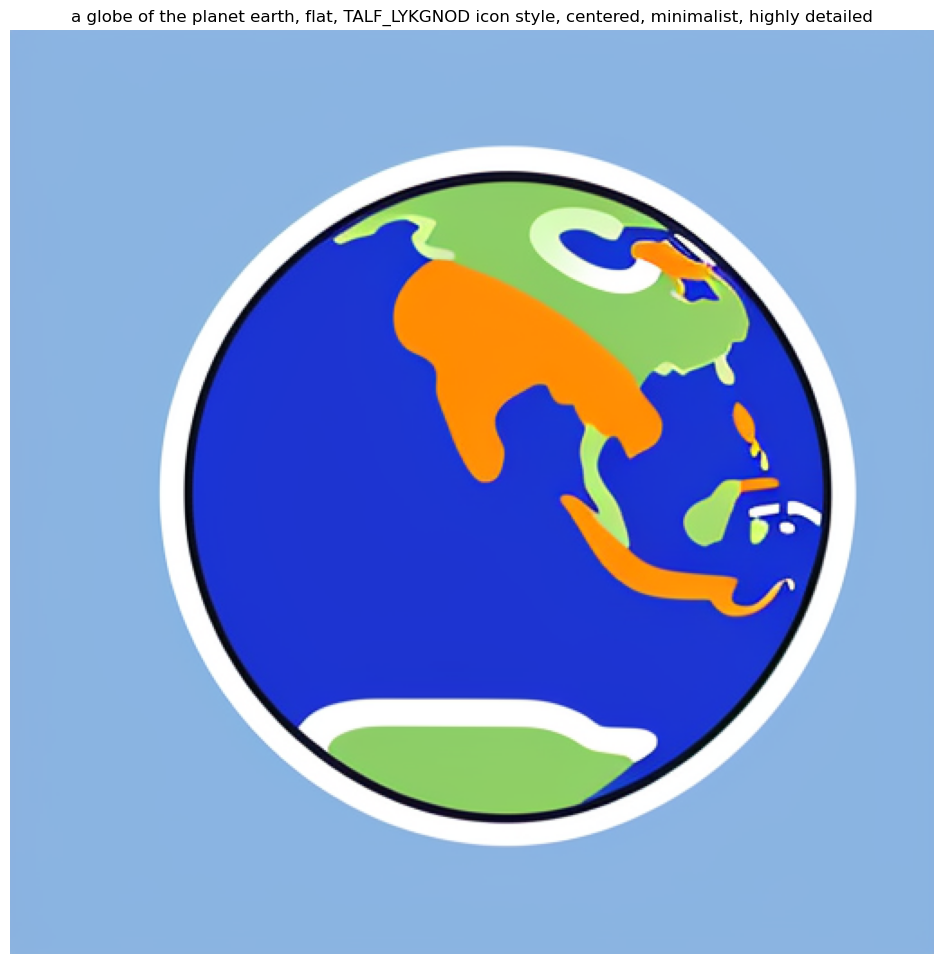

In [112]:
payload = {
    "prompt": "a handset of a classic telephone",
    "negative_prompt": "cropped, shadow, out of frame, duplicate, watermark, signature, text, ugly, sketch, deformed, mutated, blurry",
    "width": 512,
    "height": 512,
    "num_images_per_prompt": 1,
    "num_inference_steps": 30,
    "guidance_scale": 14,
}

# 의자
payload['prompt'] = f"a couch, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 2

# 시계
payload['prompt'] = f"a round clock, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 3

# 카메라
payload['prompt'] = f"front side of a digital camera, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 5

# 설정
payload['prompt'] = f"three (3) different size of gears, gears are mesh together, flat, {token} style, minimalist, centered, extreme details"
payload['seed'] = 6

# 갤러리
payload['prompt'] = f"a flower with 8 patels, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 6

# 연락처
payload['prompt'] = f"upper body of a man with arms at side, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 4

# 전화기
payload['prompt'] = f"a handset of a classic telephone, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 2

# 이메일
payload['prompt'] = f"front side of a mail envelope with cover, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 8

# 인터넷
payload['prompt'] = f"a globe of the planet earth, flat, {token} style, centered, minimalist, extreme details"
payload['seed'] = 2

# for _ in range(5):
query_response = query_endpoint_with_json_payload(
    finetuned_predictor, payload, "application/json", "application/json"
)
generated_images, prompt = parse_response_multiple_images(query_response)
display_img_and_prompt(generated_images[0], prompt)

## 6. 리소스 삭제

- 아래 주석처리 제거후 실행 

In [ ]:
# finetuned_predictor.delete_model()
# finetuned_predictor.delete_endpoint()